In [1]:
import numpy as np
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

class burr_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta, tau, Lambda):
        return 1 - pow( beta / ( beta + pow(x, tau) ), Lambda)
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
burr = burr_gen(a=0.0, name='burr')

In [2]:
N, k, beta, tau, Lambda = 1000, 100, 1, 0.5, 2
r = burr.rvs(beta, tau, Lambda, size = N)
np.mean(r)

4.552329507932205

In [3]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%'])
t.add_row(['Burr',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
           "%.3f" % round(np.percentile(r, 2.5),m), 
           "%.3f" % round(np.percentile(r, 25),m), 
           "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 75),m), 
           "%.3f" % round(np.percentile(r, 97.5),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+-------+--------+-------+-------+-------+-------+--------+
| pr.distr. |  mean |   sd   |  2.5% |  25%  |  50%  |  75%  | 97.5%  |
+-----------+-------+--------+-------+-------+-------+-------+--------+
|    Burr   | 4.552 | 32.992 | 0.000 | 0.024 | 0.184 | 1.103 | 30.747 |
+-----------+-------+--------+-------+-------+-------+-------+--------+


In [4]:
def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = asarray([a-u for x in a])
    return(a[1].tolist(), u) # u the starting value from which we consider others as excesses

In [5]:
# k = 100 # number of excesses # above
burr, u = k_greatest_values(r, k)
# frechet # so we recover  k = 100 excesses sampled from Frechet distribution

In [6]:
import pystan
from pystan import StanModel 
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  // c ~ uniform(0,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [7]:
data = dict(N = k,  y = burr) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f5534f12167b1e11be9c0c4dfd4126d NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_1f5534f12167b1e11be9c0c4dfd4126d.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.22    0.03   0.28   0.77   1.03   1.16   1.35   1.89     99   1.01
beta   11.69    0.47   4.49   5.48   8.56  10.82  13.81  22.54     90   1.01
lp__  -409.4    0.12   1.14 -412.5 -409.8 -409.1 -408.6 -408.3     90   1.01

Samples were drawn using NUTS at Wed May 16 10:59:00 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
beta = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
print("alpha = ", alpha, "\n beta = ", beta)
gamma = 1 / alpha 

def quantile_GPD(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05

quant_GPD = quantile_GPD(N, k, 0.05, beta, gamma, u)

alpha =  1.217731811339228 
 beta =  11.690329935418294


In [9]:
quant_GPD

13.775209435220113

In [10]:
beta_values = list(fit.extract().values())[1].tolist()
alpha_values = list(fit.extract().values())[0].tolist()

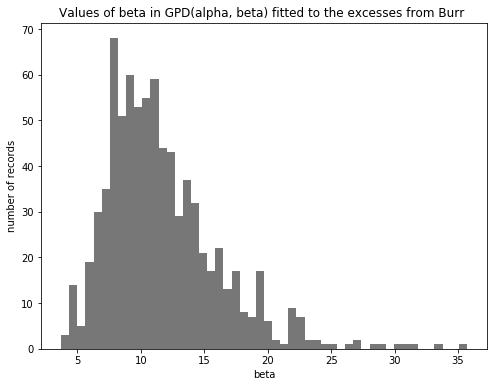

In [11]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Burr ")

# set x-axis name
ax.set_xlabel("beta")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(beta_values, bins=50, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 50:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()

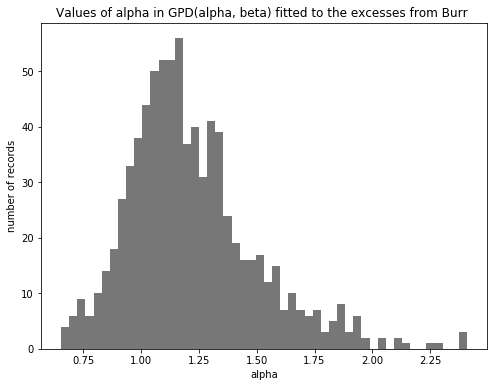

In [12]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha in GPD(alpha, beta) fitted to the excesses from Burr ")

# set x-axis name
ax.set_xlabel("alpha")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha_values, bins=50, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 50:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()

In [13]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}

data { 
  int N;
  real y[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;
  
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  //alpha1 ~ uniform(0,2);
  alpha2 ~ gamma(2,2);
  beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [14]:
data = dict(N = k,  y = burr) 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7407f4ac5ee146989f26dd1ed73d4db NOW.


Inference for Stan model: anon_model_f7407f4ac5ee146989f26dd1ed73d4db.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   1.34    0.02   0.26   0.91   1.15   1.31    1.5   1.95    269    1.0
alpha2   0.72  6.3e-3   0.12   0.51   0.63   0.72    0.8   0.97    354    1.0
beta     2.99    0.06   1.15   1.27   2.15   2.79   3.71    5.6    395    1.0
lp__   -418.3    0.08   1.33 -421.7 -418.9 -417.9 -417.3 -416.8    273    1.0

Samples were drawn using NUTS at Wed May 16 10:59:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
beta = np.mean(list(fit.extract().values())[2].tolist())
alpha2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1 = np.mean(list(fit.extract().values())[0].tolist())
print("alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta)
# gamma = 1 / alpha 

alpha1 =  1.3388799617115301 
 alpha2 =  0.7211946129688434 
 beta =  2.9943709360978916


In [16]:
# the parameter values are totall shit, i will try to get back to it later, with respect to work I want to try  

In [17]:
alpha1_values = list(fit.extract().values())[0].tolist()
alpha2_values = list(fit.extract().values())[1].tolist()
beta_values = list(fit.extract().values())[2].tolist()


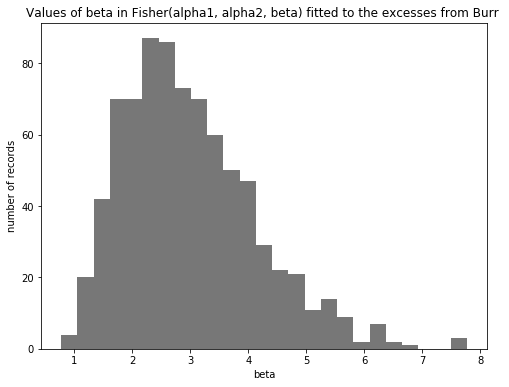

In [18]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of beta in Fisher(alpha1, alpha2, beta) fitted to the excesses from Burr ")

# set x-axis name
ax.set_xlabel("beta")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(beta_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

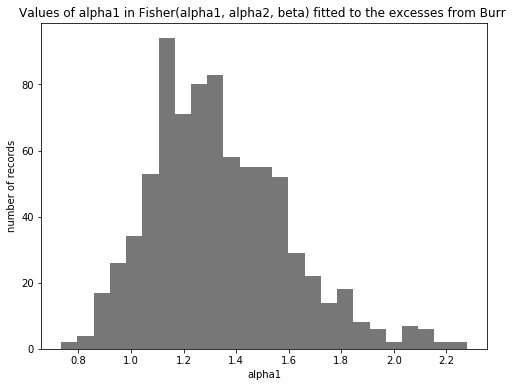

In [19]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha1 in Fisher(alpha1, alpha2, beta) fitted to the excesses from Burr ")

# set x-axis name
ax.set_xlabel("alpha1")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha1_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

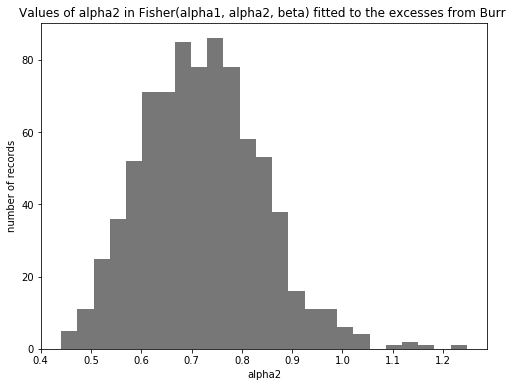

In [28]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha2 in Fisher(alpha1, alpha2, beta) fitted to the excesses from Burr ")

# set x-axis name
ax.set_xlabel("alpha2")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha2_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()

In [25]:
#ok, next step would be to average ovet multiple datasets ctreated from the given number of excesses in Burr distribution
print(" alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta, "\n u = ", u)

 alpha1 =  1.3388799617115301 
 alpha2 =  0.7211946129688434 
 beta =  2.9943709360978916 
 u =  4.810203382522611


In [29]:
#quantiles of Fisher, inverse survival function
import scipy.integrate as integrate
import scipy.special as special

def isf(alpha1, alpha2, beta, u):
    const = 1/special.beta(alpha1, alpha2)
    I = integrate.quad(lambda x : pow(x, alpha1 - 1 ) / pow(1 + x, alpha1 + alpha2), 0, u / beta)
    sf = 1 - I[0]
    isf = pow(sf, -1)
    return isf

In [30]:
result = isf(alpha1, alpha2, beta, u)
result

1.8066285885665676

In [ ]:
# I don't understand- in notes we have that isf takes in arguments n,p,k but in hand calculation these arguments do not appear
def quant_Fisher(isf, u, n, p, k):
    return u +  